In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import AdamW
import numpy as np
import copy
from collections import deque
import gymnasium as gym

from itertools import count
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader

from gymnasium.wrappers import NormalizeReward
from gymnasium.spaces import Discrete, Box

import matplotlib.pyplot as plt

In [2]:
#!pip install ipdb
#import ipdb

In [3]:
env_name = 'LunarLanderContinuous-v2'

In [4]:
# ActorCritic Network
class ActorCriticNet(nn.Module):
    def __init__(self, input_size, hidden_units=64, output_size=2):
        super(ActorCriticNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU()
        )
        self.actor_head = nn.Linear(int(hidden_units/2),  output_size)
        self.value_head = nn.Linear(int(hidden_units/2), 1)

    def forward(self, x):
        x = self.model(x)
        loc = torch.tanh(self.actor_head(x))
        value = self.value_head(x)
        return loc, value

    def __call__(self, x):
        out = self.forward(x)
        return out

In [5]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [6]:
env = gym.vector.make(env_name, num_envs=8)
#env = NormalizeReward(env)
obs_dim = env.single_observation_space.shape[0]
n_acts = env.single_action_space.shape[0]

In [7]:
# Actor-Critic networks
hidden_sizes = 128
ac_net = ActorCriticNet(obs_dim, hidden_sizes, n_acts)
ac_net = ac_net.apply(initialize_weights)

In [8]:
# optimizer
optimizer = AdamW(ac_net.parameters(), lr=0.0003)

In [9]:
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

In [11]:
@torch.no_grad()
def run_test(trajectories, policy, render=False):
    env2 = gym.make(env_name)
    scores = []
    for trajectory in range(trajectories):
        trajectory_return = 0
        obs, info = env2.reset()
        terminated = False
        truncated = False
        while (not terminated) and (not truncated):
            with torch.no_grad():
                action_loc,_ = policy(T(obs).unsqueeze(0))
            next_obs, reward, terminated,truncated, _ = env2.step(action_loc.tolist()[0])
            obs = next_obs
            trajectory_return += reward
        scores.append(trajectory_return)
    del env2
    return np.mean(scores)

In [12]:
results = deque(maxlen=50)
graph_results = []
gamma=.99
nsteps= 128
obs, info = env.reset()
for epoc in count():
    for steps in range(nsteps):
        action_loc, state_value = ac_net(T(obs))

        dist = Normal(loc=action_loc, scale=1.0)
        action = dist.sample()
        next_obs, reward, terminated, truncated, _ = env.step(action.numpy())
        
        _, next_state_value = ac_net(T(next_obs))
        next_state_value[terminated] = 0.0
        target = T(reward).unsqueeze(1) + gamma * next_state_value

        optimizer.zero_grad()
        value_loss =  F.smooth_l1_loss(target, state_value)        
        advantage = (target - state_value).detach()
        advantage = (advantage - torch.mean(advantage)) / (torch.std(advantage) + 1e-6)
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        policy_loss = -(log_prob * advantage).mean() + 0.001*entropy.mean()
        
        (policy_loss + 0.5*value_loss).backward()
        optimizer.step()

        obs = next_obs
        

    current_result = run_test(1, ac_net)
    results.append(current_result)
    graph_results.append(current_result)
    score  = np.mean(results)
    if epoc>1 and epoc % 10 == 0:
        print(f'epoch: {epoc} \t return: {score}')
    if score >= 195:
        print(f'Solved! epoch: {epoc} \t return: {score}')
        break

epoch: 10 	 return: -153.45473960980112
epoch: 20 	 return: -225.16748925861967
epoch: 30 	 return: -223.07195708587074
epoch: 40 	 return: -227.35048465180026
epoch: 50 	 return: -214.3556559748345
epoch: 60 	 return: -196.8119904218376
epoch: 70 	 return: -119.43822836765796
epoch: 80 	 return: -41.53968863743381
epoch: 90 	 return: 47.07960942452562
epoch: 100 	 return: 105.3922585966433
epoch: 110 	 return: 150.96803087466608
epoch: 120 	 return: 179.15209174232655
epoch: 130 	 return: 179.26612024255508
epoch: 140 	 return: 178.25809255381918
epoch: 150 	 return: 181.92510504580412
epoch: 160 	 return: 165.2966610854807
epoch: 170 	 return: 153.22506569018645
epoch: 180 	 return: 125.53226727884723
epoch: 190 	 return: 92.94576599773843
epoch: 200 	 return: 100.8913437348391
epoch: 210 	 return: 129.5544508321041
epoch: 220 	 return: 141.27109960323773
epoch: 230 	 return: 166.72247395468355
Solved! epoch: 236 	 return: 196.39346356530797


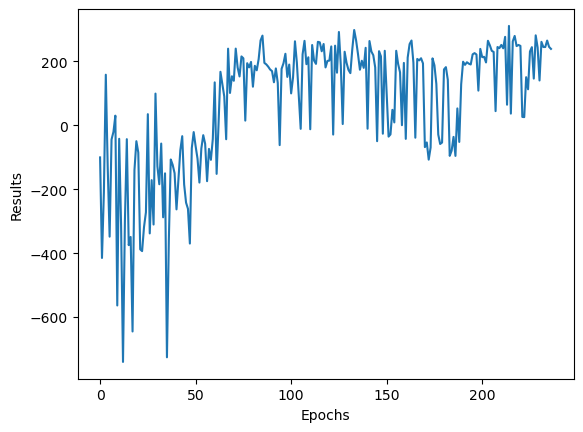

In [16]:
x = range(0,epoc+1)
y = graph_results

plt.plot(x, y)
plt.xlabel('Epochs')
plt.ylabel('Results')
plt.show()